In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import imp
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVC
from sklearn.model_selection import train_test_split
import whoscored
import seaborn as sns
from unidecode import unidecode
import pickle
import difflib
import glob
%matplotlib inline

## Data Processing

In [17]:
teams = {}
for file in glob.glob('./games/*.json'):
    with open(file,'r') as f:
        teams[file.split('/')[2].split('_')[0]] = json.load(f)

In [21]:
def get_position_sub(row):
    if row['Position'] == 'Sub':
        name = row['Player']
        try:
            row['Position'] = [k for k in df[df.Player == name].Position.value_counts().index if k !='Sub'][0]
        except:
            row['Position'] = 'substitute'
    return row

stop_words = ['<','Bl.', 'Exc.', '>']
def mean_rating(row):
    if pd.isnull(row['Rating_LEquipe']) or row['Rating_LEquipe'] in stop_words:
        name = row['Player']
        temp = df[(df.Player == name) & (~df.Rating_LEquipe.isin(stop_words)) & (pd.notnull(df.Rating_LEquipe))]
        if len(temp) > 4:
            row['Rating_LEquipe'] = np.mean(temp.Rating_LEquipe.apply(int))
    return row

position_mapping = {'attackingmidfieldcenter' : 'attackingmidfield',
 'attackingmidfieldleft' : 'attackingmidfield',
 'attackingmidfieldright' : 'attackingmidfield',
 'defenderleft' : 'defenderlateral',
 'defendermidfieldcenter' : "defendermidfield",
 'defendermidfieldleft' : 'defendermidfield',
 'defendermidfieldright': "defendermidfield",
 'defenderright': 'defenderlateral',
 'forwardleft' : 'forwardlateral',
 'forwardright' : 'forwardlateral',
 'midfieldcenter' :'midfield' ,
 'midfieldleft' :'midfield' ,
 'midfieldright' :'midfield' }

mapping_team_name = {'ASM': 'Monaco',
 'ASNL': 'Nancy',
 'ASSE': 'Saint-Etienne',
 'DFCO': 'Dijon',
 'EAG': 'Guingamp',
 'FCGB': 'Bordeaux',
 'FCL': 'Lorient',
 'FCM': 'Metz',
 'FCN': 'Nantes',
 'Losc': 'Lille',
 'MHSC': 'Montpellier',
 'Man. City': 'Manchester City',
 'Man. United': 'Manchester United',
 'OGCN': 'Nice',
 'OL': 'Lyon',
 'OM': 'Marseille',
 'PSG': 'Paris Saint Germain',
 'Palace': 'Crystal Palace',
 'SCB': 'SC Bastia',
 'SCO': 'Angers',
 'SMC': 'Caen',
 'SRFC': 'Rennes',
 'Stoke City': 'Stoke',
 'TFC': 'Toulouse',
 'WBA': 'West Bromwich Albion'}

In [138]:
df = pd.DataFrame()
for team, file in teams.items():
    for i, game in enumerate(file):
        temp = pd.DataFrame(game['stats'])
        temp['Opponent'] = game['opponent']
        temp['Place'] = game['place'].title()
        result = game['result'].split(' : ')
        temp['Goal Team'] = int(result[int(game['place'] == 'away')])
        temp['Goal Opponent'] = int(result[int(game['place'] == 'home')])
        temp['Team'] = {'psg':'Paris Saint Germain'}.get(team, team).title()
        temp['Team'] = {'Bastia': 'SC Bastia'}.get(temp['Team'][0], temp['Team'][0])
        temp['Day'] = i+1
        df = pd.concat([df, temp])
df = df.apply(whoscored.get_name, axis=1).reset_index(drop=True)
df['LineUp'] = 1
df.loc[df.Position == 'Sub', 'LineUp'] = 0
df = df.apply(get_position_sub, axis=1)
df.Goal.fillna(0, inplace=True)
df.Assist.fillna(0, inplace=True)
df.Yellowcard.fillna(0, inplace=True)
df.Redcard.fillna(0, inplace=True)
df.Penaltymissed.fillna(0, inplace=True)
df.Shotonpost.fillna(0, inplace=True)
# df.Position = df.Position.apply(lambda x:position_mapping.get(x,x))

In [139]:
with open('./ratings/notes_ligue1_lequipe.json','r') as f:
    rating_lequipe  = json.load(f)
rating_lequipe = {mapping_team_name.get(k,k):[p for p in v if list(p.keys())[0] != 'Nom' and len(list(p.values())[0]) > 0] 
                    for k,v in rating_lequipe.items()}

In [140]:
for team_name, rating_team in rating_lequipe.items():
    if team_name in set(df.Team):
        players_lequipe = [list(k.keys())[0] for k in rating_team]
        players_df = list(set(df[df.Team == team_name].Player))
        for player in rating_team:
            [(player_name, player_ratings)] = player.items()
            try:
                player_name_df = difflib.get_close_matches(player_name, players_df)[0]
            except:
                if len(unidecode(player_name).split('-')) > 1 :
                    player_name_df = [k for k in players_df if unidecode(player_name).split('-')[0].replace("'","").lower() in unidecode(k).replace("'","").lower()
                                                             or unidecode(player_name).split('-')[1].replace("'","").lower() in unidecode(k).replace("'","").lower()][0]
                else:
                    player_name_df = [k for k in players_df if unidecode(player_name).replace("'","").lower() in unidecode(k).replace("'","").lower()][0]
            for day, rating in player_ratings.items():
                df.loc[(df.Player == player_name_df) & (df.Team == team_name) & (df.Day == int(day.split('Day ')[1])), 'Rating_LEquipe'] = rating
df = df.apply(mean_rating, axis=1)
df.drop('null', axis=1, inplace=True)

In [141]:
print('%d/%d données avec une note l\'Équipe' % (len(df[(~df.Rating_LEquipe.isin(stop_words)) & (pd.notnull(df.Rating_LEquipe))]),
                                                len(df)))
df[['Team','Goal Team', 'Goal Opponent', 'Player', 'Goal',
    'Opponent', 'Day', 'Position', 'Age', 'LineUp', 'Rating_LEquipe']].sort_values('Player').sample(8)

9552/10187 données avec une note l'Équipe


,Team,Goal Team,Goal Opponent,Player,Goal,Opponent,Day,Position,Age,LineUp,Rating_LEquipe
415,Paris Saint Germain,2,1,Thiago Motta,0.0,Lyon,30,midfieldcenter,34,0,5
9580,Toulouse,0,0,Mauro Goicoechea,0.0,Rennes,30,goalkeeper,29,1,7
5736,Metz,0,1,Thomas Didillon,0.0,Rennes,11,goalkeeper,21,1,5
6440,Nantes,1,1,Rémy Riou,0.0,Metz,25,goalkeeper,29,1,5
3446,Lille,1,0,Eder,0.0,SC Bastia,31,forward,29,1,4
9100,Saint-Etienne,1,1,Kevin Malcuit,0.0,Rennes,33,defenderright,25,1,5.42105
5640,Metz,3,0,Yann Jouffre,0.0,Nantes,4,attackingmidfieldright,32,0,4.88889
2401,Angers,3,0,Abdoulaye Bamba,0.0,SC Bastia,27,defenderright,27,1,6


In [143]:
with open('./df.pkl', 'rb') as f:
    df = pickle.load(f)

In [176]:
other_cols = ['Day', "Opponent", "Place", "Player", "Position", 
                "Team", 'Key Events', "Rating_LEquipe"]
col_delete = ['Key Events', "Rating_LEquipe", 'Rating', 'Day']
cols_to_transf = [col for col in df.columns if col not in other_cols]
p = pd.concat([df[cols_to_transf].applymap(float), df[other_cols]], axis=1)
new_col_to_remov = [e for e in p.columns if e.startswith('Acc')] + ['Touches']

## Learning

In [177]:
p = p[(~p.Rating_LEquipe.isin(stop_words)) & (pd.notnull(p.Rating_LEquipe))].set_index('Player')
X = p[[col for col in p.columns if col not in col_delete + new_col_to_remov]]
y = p['Rating_LEquipe'].apply(float)

In [178]:
label_encoders = {}
col_encode = ["Opponent", "Place", "Position", "Team"]
for col in col_encode:
    label_encoders[col.lower()] = LabelEncoder()
    X[col] = label_encoders[col.lower()].fit_transform(X[col])

/Users/alexandreattia/Desktop/Work/workenv/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [223]:
d = []
k_fold = 5
for k in range(k_fold): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/k_fold)
    ridge = Ridge(alpha=0.001, max_iter=10000, tol=0.0001)
    ridge.fit(X_train, y_train)
    d.append(np.mean((ridge.predict(X_test) - y_test) ** 2))
print('%d-fold cross validation mean square error : %.2f' % (k_fold, np.mean(d)))
ridge = Ridge(alpha=0.001, max_iter=10000, tol=0.0001)
_ = ridge.fit(X, y)

5-fold cross validation mean square error : 0.86


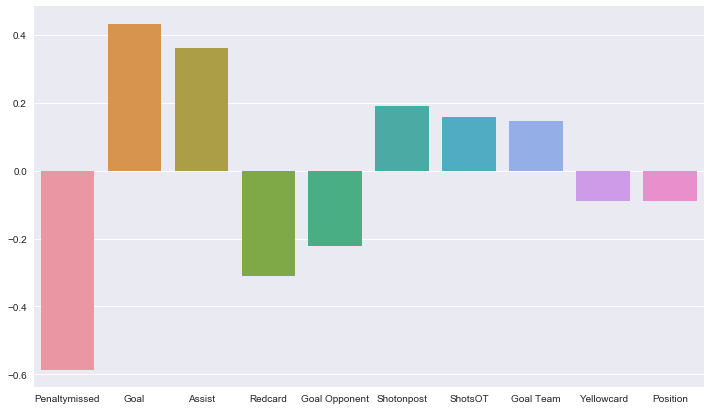

In [191]:
f,ax = plt.subplots(figsize=(12,7))
top_k = 10
l = np.argsort(list(map(np.abs, ridge.coef_)))[::-1][:top_k]
coeff_imp = [(X_train.columns[ll],ridge.coef_[ll]) for ll in l]
# print("The %d most important parameters are:\n%s" % (top_k,'\n'.join(['%s : %.2f' % (a,b) for a,b in coeff_imp])))
sns.barplot([a[0] for a in coeff_imp], [a[1] for a in coeff_imp])

In [232]:
rf = RandomForestRegressor(oob_score=True, n_estimators=100)
rf.fit(X, y)
print('RF : oob score : %.2f' % rf.oob_score_)
d = []
k_fold = 5
for k in range(k_fold): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/k_fold)
    rf = RandomForestRegressor(oob_score=True, n_estimators=100, )
    rf.fit(X_train, y_train)
    d.append(np.mean((rf.predict(X_test) - y_test) ** 2))
print('RF : %d-fold cross validation mean square error : %.2f' % (k_fold, np.mean(d)))

RF : oob score : 0.34
RF : 5-fold cross validation mean square error : 0.73
